<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/Dynamic_fire_test_urban.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
%%time 
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

# install rasterio
!pip install rasterio

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
4 packages can be upgraded. Run 'apt

In [23]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from osgeo import gdal_array
import numpy as np
import pandas as pd
import imageio
import random
from PIL import Image
from matplotlib.pyplot import imshow

In [25]:
path = '/content/drive/My Drive/04_Cloud/01_Work/GNS/008_FFE/Colab_folder'
!ls '/content/drive/My Drive/04_Cloud/01_Work/GNS/008_FFE/Colab_folder'

Fire_scenario_1.gif   GD_ignit_prob_crop.tif  img1.png
GD_fuel_map_crop.tif  GD_ignit_prob.tif       img2.png
GD_fuel_map.tif       GD_wind.csv	      img.png


In [0]:
def load_data(path_to_data=path):
    # load building map as a "fuel" map
    fuel = gdal_array.LoadFile(os.path.join(path_to_data, 'GD_fuel_map_crop.tif'))  # 0 = no fuel; 1 = fuel
    fuel[fuel < 0] = 0
    # load probability of building ignition as an array
    ignition = gdal_array.LoadFile(os.path.join(path_to_data, 'GD_ignit_prob_crop.tif'))  # probability from 0 to 1
    ignition[ignition < 0] = 0
    # load wind data
    wind = pd.read_csv(os.path.join(path_to_data, 'GD_wind.csv'))
    return fuel, ignition, wind

In [0]:
fuel_map, ignition_probability_map, wind_df = load_data()

In [0]:
def wind_scenario(wind_data=wind_df):
    i = np.random.randint(0, wind_data.shape[0])
    wind = wind_data.iloc[i, 2]
    distance = wind_data.iloc[i, 1]
    return wind, distance

In [0]:
def gif(fireMap, s):
  colored = np.zeros((fireMap.shape[0], fireMap.shape[1], fireMap.shape[2], 3),dtype=np.uint8)
  for t in range(fireMap.shape[0]):
      for x in range(fireMap[t].shape[0]):
          for y in range(fireMap[t].shape[1]):
            # print(t, x, y)
            value = fireMap[t,x,y].copy()
            if value == 0:
                  colored[t,x,y] = [0, 0, 255] # Clear
            elif value == 1: 
                colored[t,x,y] = [255, 128, 0]   # Fuel
            elif value == 2: 
                colored[t,x,y] = [255,0,0]   # Burning

  imageio.mimsave(os.path.join(path, 'Fire_scenario_{}.gif'.format(s)), colored)
  print('Fire_scenario_{}.gif created'.format(s))

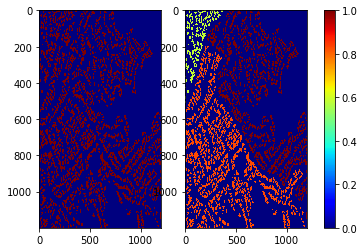

In [57]:
fig, ax = plt.subplots(ncols=2)
im0 = ax[0].imshow(fuel_map, cmap='jet', aspect='auto')
im1 = ax[1].imshow(ignition_probability_map, cmap='jet', aspect='auto')

plt.colorbar(im0, ax=ax) 
plt.show()

In [0]:
def fire_propagation(scenarios, fuel=fuel_map, ignition_proba=ignition_probability_map):
    fire_final_list = []
    for scenario in range(scenarios):
        wind, distance = wind_scenario()
        print(wind, distance)
        time_total = 1000
        # initialize fire by creating random ignition from ignition probability map
        random_map = np.random.random((ignition_proba.shape[0], ignition_proba.shape[1]))
        ignition_map = ignition_proba - random_map
        ignition_map[ignition_map < 0] = 0
        ignition_map[ignition_map > 0] = 1
        zeros = np.zeros((fuel_map.shape[0], fuel_map.shape[1], time_total - 1))
        ignition_map = np.expand_dims(ignition_map, axis=2)
        ignition = np.dstack((zeros, ignition_map))
        ignition = np.moveaxis(ignition, -1, 0)
        # initial fire map
        fire = np.zeros((time_total, fuel_map.shape[0], fuel_map.shape[1]))
        fire[0] = ignition[0] + fuel  # 0 = no fuel, 1 = fuel, 2 = fire

        for time in range(1, time_total, 1):
            # Make a copy of the original fire
            fire[time] = fire[time - 1].copy()
            for x in range(1, fire[0] - 1):
                for y in range(1, fire[1] - 1):
                    for d in range(distance, 1, -1):
                        if fire[time - 1, x, y] == 2 and wind == 'buffer':  # It's on fire
                            # If there's fuel surrounding it
                            # set it on fire!
                            if fire[time - 1, x - distance, y + distance] == 1:
                                fire[time, x - distance, y + distance] = 2
                            if fire[time - 1, x, y + distance] == 1:
                                fire[time, x, y + distance] = 2
                            if fire[time - 1, x + distance, y + distance] == 1:
                                fire[time, x + distance, y + distance] = 2
                            if fire[time - 1, x + distance, y] == 1:
                                fire[time, x + distance, y] = 2
                            if fire[time - 1, x + distance, y - distance] == 1:
                                fire[time, x + distance, y - distance] = 2
                            if fire[time - 1, x, y - distance] == 1:
                                fire[time, x, y - distance] = 2
                            if fire[time - 1, x - distance, y - distance] == 1:
                                fire[time, x - distance, y - distance] = 2
                            if fire[time - 1, x - distance, y] == 1:
                                fire[time, x - distance, y] = 2

                        if fire[time - 1, x, y] == 2 and wind == 'N':  # It's on fire
                            # set it on fire!
                            if fire[time - 1, x - distance, y + distance] == 1:
                                fire[time, x - distance, y + distance] = 2
                            if fire[time - 1, x, y + distance] == 1:
                                fire[time, x, y + distance] = 2
                            if fire[time - 1, x + distance, y + distance] == 1:
                                fire[time, x + distance, y + distance] = 2

                        if fire[time - 1, x, y] == 2 and wind == 'NE':  # It's on fire
                            # set it on fire!
                            if fire[time - 1, x, y + distance] == 1:
                                fire[time, x, y + distance] = 2
                            if fire[time - 1, x + distance, y + distance] == 1:
                                fire[time, x + distance, y + distance] = 2
                            if fire[time - 1, x + distance, y] == 1:
                                fire[time, x + distance, y] = 2

                        if fire[time - 1, x, y] == 2 and wind == 'E':  # It's on fire
                            # set it on fire!
                            if fire[time - 1, x + distance, y + distance] == 1:
                                fire[time, x + distance, y + distance] = 2
                            if fire[time - 1, x + distance, y] == 1:
                                fire[time, x + distance, y] = 2
                            if fire[time - 1, x + distance, y - distance] == 1:
                                fire[time, x + distance, y + distance] = 2

                        if fire[time - 1, x, y] == 2 and wind == 'SE':  # It's on fire
                            # set it on fire!
                            if fire[time - 1, x + distance, y] == 1:
                                fire[time, x + distance, y] = 2
                            if fire[time - 1, x + distance, y - distance] == 1:
                                fire[time, x + distance, y + distance] = 2
                            if fire[time - 1, x, y - distance] == 1:
                                fire[time, x, y - distance] = 2

                        if fire[time - 1, x, y] == 2 and wind == 'S':  # It's on fire
                            # set it on fire!
                            if fire[time - 1, x, y - distance] == 1:
                                fire[time, x, y - distance] = 2
                            if fire[time - 1, x - distance, y - distance] == 1:
                                fire[time, x - distance, y - distance] = 2
                            if fire[time - 1, x + distance, y - distance] == 1:
                                fire[time, x + distance, y - distance] = 2

                        if fire[time - 1, x, y] == 2 and wind == 'SW':  # It's on fire
                            # set it on fire!
                            if fire[time - 1, x, y - distance] == 1:
                                fire[time, x, y - distance] = 2
                            if fire[time - 1, x - distance, y - distance] == 1:
                                fire[time, x - distance, y - distance] = 2
                            if fire[time - 1, x - distance, y] == 1:
                                fire[time, x - distance, y] = 2

                        if fire[time - 1, x, y] == 2 and wind == 'W':  # It's on fire
                            # set it on fire!
                            if fire[time - 1, x - distance, y + distance] == 1:
                                fire[time, x - distance, y + distance] = 2
                            if fire[time - 1, x - distance, y - distance] == 1:
                                fire[time, x - distance, y - distance] = 2
                            if fire[time - 1, x - distance, y] == 1:
                                fire[time, x - distance, y] = 2

                        if fire[time - 1, x, y] == 2 and wind == 'NW':  # It's on fire
                            # set it on fire!
                            if fire[time - 1, x - distance, y + distance] == 1:
                                fire[time, x - distance, y + distance] = 2
                            if fire[time - 1, x - distance, y] == 1:
                                fire[time, x - distance, y] = 2
                            if fire[time - 1, x, y + distance] == 1:
                                fire[time, x, y + distance] = 2

                        
                        im = Image.fromarray(fire[time])
                        im.show()

                        if np.array_equal(fire[time], fire[time - 1]) == True:
                            fire_list.append(fire[time])
                            pass
                        else:
                            continue

          gif(fire, scenario)

    return fire_final_list

In [0]:
final_fires_list = fire_propagation(5)

In [0]:

final_fires_array = np.array(final_fire_list)
fire_impact = np.sum(final_fires_array)